# Figure 1: Gencode Analyses

- annotated TF isoforms
- expression across GTEx/Dev RNA-seq
- domain alterations

In [1]:
import sys
import itertools
from itertools import combinations
from decimal import Decimal
sys.path.append("../")

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

from poibin import PoiBin
from data_loading import (load_annotated_gencode_tfs,
                          load_gtex_gencode,
                          load_developmental_tissue_expression_gencode,
                          load_tf_families,
                          load_pfam_clans,
                          load_DNA_binding_domains)

# to load alignment function from isolib
from data_loading.isolib import _coords_transform_aa_seq_to_alignment

from plotting import mimic_r_boxplot

/PHShome/kz659/.conda/envs/tfisos/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
SEED = 2023
np.random.seed(SEED)

In [3]:
PAPER_PRESET = {"style": "ticks", "font": ["Helvetica", "DejaVu Sans"], "context": "paper",
                "rc": {"font.size":7,"axes.titlesize":7,
                     "pdf.fonttype": 42, 
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## 1. load Gencode TFs + GTEx + Dev RNA-seq

In [4]:
tfs = load_annotated_gencode_tfs()

df_gtex, metadata_gtex, genes_gtex = load_gtex_gencode()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_gencode()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())
all_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values() for orf in tf.isoforms}
alt_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and not orf.is_MANE_select_transcript}
ref_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript}

Filtering GENCODE .gtf file. Takes a few minutes but only needs to be done once.


100%|██████████| 3881/3881 [02:50<00:00, 22.79it/s] 


more than one match for KRK ZFHX3
skipping
more than one match for KRK NFATC1
skipping
more than one match for KRK NFATC1
skipping
more than one match for KRK AKAP8L
skipping
reading from cache
reading from cache


In [5]:
means_dev.columns[70:100]

Index(['kidney 19', 'kidney child', 'kidney infant', 'kidney neonate',
       'kidney toddler', 'liver 04', 'liver 05', 'liver 06', 'liver 07',
       'liver 08', 'liver 09', 'liver 10', 'liver 11', 'liver 12', 'liver 13',
       'liver 16', 'liver 18', 'liver 19', 'liver adolescent', 'liver adult',
       'liver child', 'liver elderly', 'liver infant', 'liver neonate',
       'liver toddler', 'liver young adult', 'ovary 04', 'ovary 05',
       'ovary 06', 'ovary 07'],
      dtype='object')

In [6]:
print(means_gtex.shape[1], 'tissues in GTEx RNA-seq')
print(means_dev.shape[1], 'tissue/timepoint in Developmental RNA-seq')

n_samples_dev = df_dev.groupby(
    df_dev.columns.map(
        metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']
    ),
    axis=1,
).size()
n_samples_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).size()
print(f'{n_samples_dev.min()}-{n_samples_dev.max()}, median={n_samples_dev.median()} samples in Developmental RNA-seq')
print(f'{n_samples_gtex.min()}-{n_samples_gtex.max()}, median={n_samples_gtex.median()} samples in GTEx')

51 tissues in GTEx RNA-seq
127 tissue/timepoint in Developmental RNA-seq
1-5, median=2.0 samples in Developmental RNA-seq
5-379, median=24.0 samples in GTEx


In [7]:
n_samples_gtex.value_counts().sort_index()

5       1
6       1
7       1
10      1
24     34
27      1
29      1
32      2
33      1
35      1
36      1
138     1
161     1
173     1
206     1
360     1
379     1
Name: count, dtype: int64

In [8]:
print("NUMBER OF TF ISOFORMS IN GENCODE: %s" % len(all_isos))

NUMBER OF TF ISOFORMS IN GENCODE: 4144


In [9]:
print("NUMBER OF TF GENES IN GENCODE: %s" % len(tfs))

NUMBER OF TF GENES IN GENCODE: 1635


In [10]:
print("NUMBER OF REF ISOS IN GENCODE: %s" % len(ref_isos))

NUMBER OF REF ISOS IN GENCODE: 1514


In [11]:
print("NUMBER OF ALT ISOS IN GENCODE: %s" % len(alt_isos))

NUMBER OF ALT ISOS IN GENCODE: 2305


## 2. isoforms per family

In [12]:
# number of isoforms vs gene expression, publications, and exons 
tpm_per_gene = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .sum()
                .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
                .mean())
gn = tpm_per_gene.max(axis=1).rename('TPM - gene-level, max across GTEx tissues').to_frame()
gn['n_isoforms'] = gn.index.map(genes_gtex.value_counts())

In [13]:
fam = load_tf_families()
gn['family'] = gn.index.map(fam)
gn['is_nuclear_receptor'] = (gn['family'] == 'Nuclear receptor')
gn.head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,family,is_nuclear_receptor
AC008770.3,0.339530,2,C2H2 ZF,False
AC023509.3,4.475325,1,bZIP,False
AC092835.1,0.884619,1,C2H2 ZF,False
AC138696.1,1.760060,1,C2H2 ZF,False
ADNP,9157.752828,3,Homeodomain,False


In [14]:
len(gn)

1635

In [15]:
print("NUMBER OF GENES WITH >1 ISOFORM IN GENCODE: %s" % len(gn[gn["n_isoforms"] > 1]))
print("PERCENT OF GENES WITH >1 ISOFORM IN GENCODE: %s" % (len(gn[gn["n_isoforms"] > 1])/len(gn)))

NUMBER OF GENES WITH >1 ISOFORM IN GENCODE: 992
PERCENT OF GENES WITH >1 ISOFORM IN GENCODE: 0.6067278287461774


In [16]:
print("MEAN NUMBER OF ISOFORMS PER TF GENE IN GENCODE: %s" % gn.n_isoforms.mean())

MEAN NUMBER OF ISOFORMS PER TF GENE IN GENCODE: 2.5345565749235472


In [17]:
print("TFs WITH HIGHEST NUMBER OF ISOFORMS IN GENCODE:")
gn.sort_values(by="n_isoforms", ascending=False).head(5)

TFs WITH HIGHEST NUMBER OF ISOFORMS IN GENCODE:


,"TPM - gene-level, max across GTEx tissues",n_isoforms,family,is_nuclear_receptor
CREM,372.514410,25,bZIP,False
TCF4,13.551768,23,bHLH,False
NFATC4,198.651682,23,Rel,False
NR1I3,65.437841,21,Nuclear receptor,True
MYT1L,47.689698,18,C2H2 ZF,False


In [18]:
print("MEAN NUMBER OF ISOFORMS PER HOMEODOMAIN TF IN GENCODE: %s" % gn[gn["family"] == "Homeodomain"].n_isoforms.mean())

MEAN NUMBER OF ISOFORMS PER HOMEODOMAIN TF IN GENCODE: 1.8041237113402062


In [19]:
print("MEAN NUMBER OF ISOFORMS PER NR TF IN GENCODE: %s" % gn[gn["family"] == "Nuclear receptor"].n_isoforms.mean())

MEAN NUMBER OF ISOFORMS PER NR TF IN GENCODE: 3.8260869565217392


In [20]:
fam_members = pd.DataFrame(gn['family'].value_counts()).reset_index()
fam_members_ov20 = fam_members[fam_members["count"] >= 20]
fam_members_ov20

,family,count
0,C2H2 ZF,745
1,Homeodomain,194
2,bHLH,108
3,Unknown,69
4,bZIP,54
5,Forkhead,49
6,Nuclear receptor,46
7,HMG/Sox,30
8,Ets,27


In [21]:
def collapse_families(row, families_to_keep):
    if row['family'] in families_to_keep:
        return row['family']
    else:
        return 'Other'
    
gn['family_updated'] = gn.apply(collapse_families, axis=1, 
                                families_to_keep=list(fam_members[fam_members['count'] >=20]['family']))
gn.family_updated.value_counts()

family_updated
C2H2 ZF             745
Other               313
Homeodomain         194
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
Name: count, dtype: int64

In [22]:
gn["family_updated"].unique()

array(['C2H2 ZF', 'bZIP', 'Homeodomain', 'Unknown', 'Other', 'bHLH',
       'Nuclear receptor', 'HMG/Sox', 'Ets', 'Forkhead'], dtype=object)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


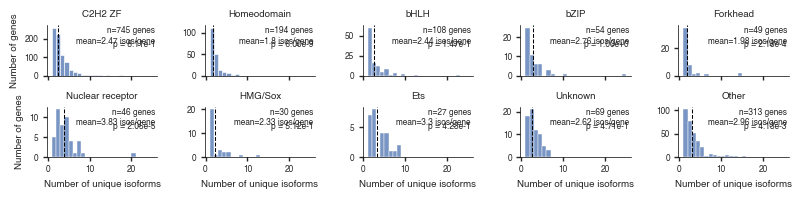

In [23]:
def annotate(data, **kws):
    n = len(data)
    mean = data.n_isoforms.mean()
    ax = plt.gca()
    ax.text(0.98, 0.98, "n=%s genes\nmean=%s isos/gene" % (n, np.round(mean, 2)), transform=ax.transAxes,
            ha="right", va="top", fontsize=fontsize-1)
    ax.axvline(x=mean, linestyle="dashed", color="black", linewidth=0.75)

g = sns.FacetGrid(gn, col="family_updated", sharex=True, sharey=False, height=1, aspect=1.6,
                  col_order=["C2H2 ZF", "Homeodomain", "bHLH", "bZIP", "Forkhead", "Nuclear receptor",
                             "HMG/Sox", "Ets", "Unknown", "Other"], col_wrap=5)
g.map_dataframe(sns.histplot, "n_isoforms", binwidth=1)
g.map_dataframe(annotate)
g.set_axis_labels("Number of unique isoforms", "Number of genes")
g.set_titles(col_template="{col_name}")


# add p-value
for ax in g.axes:
    fam = ax.get_title()
    x = list(gn[gn["family_updated"] == fam]["n_isoforms"])
    y = list(gn[gn["family_updated"] != fam]["n_isoforms"])
    p = min(stats.mannwhitneyu(x, y).pvalue * len(gn["family_updated"].unique()), 1)
    s = "{:.2e}".format(Decimal(p))
    ax.text(0.98, 0.7, "p = %s" % s, ha="right", va="top", transform=ax.transAxes, fontsize=fontsize-1)

g.savefig("../../figures/fig1/GENCODE_iso_counts_per_family.pdf", bbox_inches="tight", dpi="figure")

In [24]:
gn_mean = gn.groupby("family")["n_isoforms"].agg(["mean", "count"]).reset_index()
gn_mean.sort_values(by="count")

,family,mean,count
2,ARID/BRIGHT; RFX,4.000000,1
57,TCR/CxC,3.000000,1
5,Brinker,1.000000,1
25,FLYWCH,2.000000,1
24,Ets; AT hook,1.000000,1
...,...,...,...
62,bZIP,2.759259,54
60,Unknown,2.623188,69
61,bHLH,2.444444,108
33,Homeodomain,1.804124,194


## 3. re-sample GTEx
GTEx has more samples/condition than Dev, but Dev has more conditions

In [25]:
# conditions (body sites): gtex
len(metadata_gtex['body_site'].value_counts())

51

In [26]:
# samples per body site: gtex
metadata_gtex['body_site'].value_counts()

body_site
Lung                                         379
Thyroid                                      360
Colon - Transverse                           206
Colon - Sigmoid                              173
Adrenal Gland                                161
Liver                                        138
Kidney - Cortex                               36
Breast - Mammary Tissue                       35
Whole Blood                                   33
Muscle - Skeletal                             32
Skin - Not Sun Exposed (Suprapubic)           32
Skin - Sun Exposed (Lower leg)                29
Adipose - Subcutaneous                        27
Brain - Cortex                                24
Stomach                                       24
Pancreas                                      24
Brain - Caudate (basal ganglia)               24
Brain - Nucleus accumbens (basal ganglia)     24
Ovary                                         24
Brain - Hippocampus                           24
Vagina    

In [27]:
list(metadata_gtex['body_site'].value_counts().index)

['Lung',
 'Thyroid',
 'Colon - Transverse',
 'Colon - Sigmoid',
 'Adrenal Gland',
 'Liver',
 'Kidney - Cortex',
 'Breast - Mammary Tissue',
 'Whole Blood',
 'Muscle - Skeletal',
 'Skin - Not Sun Exposed (Suprapubic)',
 'Skin - Sun Exposed (Lower leg)',
 'Adipose - Subcutaneous',
 'Brain - Cortex',
 'Stomach',
 'Pancreas',
 'Brain - Caudate (basal ganglia)',
 'Brain - Nucleus accumbens (basal ganglia)',
 'Ovary',
 'Brain - Hippocampus',
 'Vagina',
 'Brain - Frontal Cortex (BA9)',
 'Brain - Hypothalamus',
 'Brain - Putamen (basal ganglia)',
 'Brain - Cerebellar Hemisphere',
 'Brain - Spinal cord (cervical c-1)',
 'Uterus',
 'Minor Salivary Gland',
 'Brain - Amygdala',
 'Brain - Anterior cingulate cortex (BA24)',
 'Spleen',
 'Esophagus - Muscularis',
 'Nerve - Tibial',
 'Prostate',
 'Heart - Left Ventricle',
 'Brain - Cerebellum',
 'Artery - Tibial',
 'Esophagus - Gastroesophageal Junction',
 'Small Intestine - Terminal Ileum',
 'Heart - Atrial Appendage',
 'Pituitary',
 'Esophagus - Muco

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


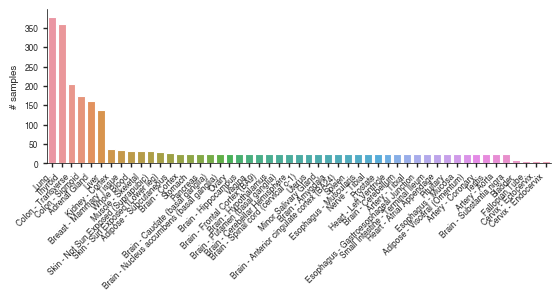

In [28]:
fig = plt.figure(figsize=(6.5, 2))

ax = sns.countplot(data=metadata_gtex, x="body_site", order=list(metadata_gtex['body_site'].value_counts().index))
ax.set_xlabel("")
ax.set_ylabel("# samples")

_ = ax.set_xticklabels(list(metadata_gtex['body_site'].value_counts().index), rotation=45, ha="right", va="top")

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
fig.savefig("../../figures/fig1/gtex-metadata.pdf", dpi="figure", bbox_inches="tight")

In [29]:
gtex_bs = pd.DataFrame(metadata_gtex['body_site'].value_counts()).reset_index()
gtex_bs.head()

,body_site,count
0,Lung,379
1,Thyroid,360
2,Colon - Transverse,206
3,Colon - Sigmoid,173
4,Adrenal Gland,161


In [30]:
# conditions (body sites): dev
metadata_dev['body_site'] = metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']
len(metadata_dev['body_site'].value_counts())

127

In [31]:
# samples per body site: dev
metadata_dev['body_site'].value_counts()

body_site
heart 08                 5
hindbrain young adult    5
forebrain young adult    5
forebrain 19             5
hindbrain neonate        5
                        ..
forebrain 18             1
heart adult              1
liver adult              1
testis adult             1
forebrain 10             1
Name: count, Length: 127, dtype: int64

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


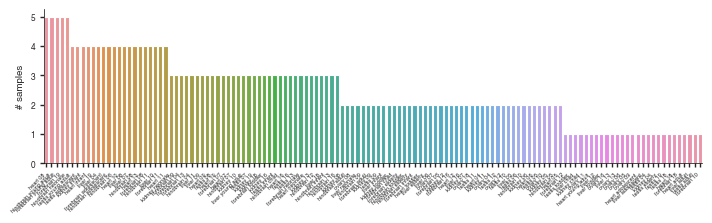

In [32]:
fig = plt.figure(figsize=(8.5, 2))

ax = sns.countplot(data=metadata_dev, x="body_site", order=list(metadata_dev['body_site'].value_counts().index))
ax.set_xlabel("")
ax.set_ylabel("# samples")

_ = ax.set_xticklabels(list(metadata_dev['body_site'].value_counts().index), rotation=45, ha="right", va="top",
                       fontsize=4)

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
fig.savefig("../../figures/fig1/dev-metadata.pdf", dpi="figure", bbox_inches="tight")

In [33]:
dev_bs = pd.DataFrame(metadata_dev['body_site'].value_counts()).reset_index()
dev_bs.head()

,body_site,count
0,heart 08,5
1,hindbrain young adult,5
2,forebrain young adult,5
3,forebrain 19,5
4,hindbrain neonate,5


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


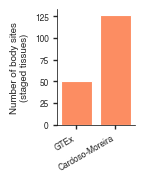

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(1, 1.5))

ax.bar(x=0, height=len(gtex_bs), color=sns.color_palette("Set2")[1])
ax.bar(x=1, height=len(dev_bs), color=sns.color_palette("Set2")[1])

ax.set_xticks([0, 1])
ax.set_xticklabels(["GTEx", "Cardoso-Moreira"], ha="right", va="top", rotation=30)
ax.set_ylabel("Number of body sites\n(staged tissues)")

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
fig.savefig("../../figures/fig1/gtex-v-dev_body-sites.pdf", dpi="figure", bbox_inches="tight")

In [35]:
gtex_bs["src"] = "GTEx"
dev_bs["src"] = "Cardoso-Moreira"
bs = pd.concat([gtex_bs, dev_bs])

/tmp/ipykernel_160231/2467289691.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["GTEx", "Cardoso-Moreira"], ha="right", va="top", rotation=30)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


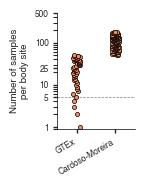

In [36]:
fig = plt.figure(figsize=(1, 1.5))

np.random.seed(SEED)
ax = sns.stripplot(data=bs, x="src", y="body_site", jitter=True, color=sns.color_palette("Set2")[1],
                   linewidth=0.5, edgecolor="black", s=3)

ax.set_xticklabels(["GTEx", "Cardoso-Moreira"], ha="right", va="top", rotation=30)
ax.set_ylabel("Number of samples\nper body site")
ax.set_xlabel("")

ax.set_yscale("log")
ax.set_yticks([1, 5, 10, 25, 100, 500])
ax.set_yticklabels([1, 5, 10, 25, 100, 500])
ax.set_ylim((0.9, 500))
ax.axhline(y=5, linestyle="dashed", linewidth=0.5, color="grey")

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
fig.savefig("../../figures/fig1/gtex-v-dev_n-samples.pdf", dpi="figure", bbox_inches="tight")

### loop through GTEx tissues and pick the # of samples by randomly matching to a dev dataset

this is inherently unstable when sampling w/o replacement as will end up with times where there are more samps in the dev that you're randomly matching to than the gtex (rare but happens). set a seed and using the same metadata sampling for all downstream figures.

In [37]:
# loop through gtex tissues
# pick number of samples according to dev dataset
# loop again
# make fake metadata file

# something about calling stripplots seems to revert seed -- reset here for reproducibility
np.random.seed(SEED)

n_samples_dev = df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).value_counts().values
np.random.shuffle(n_samples_dev)
gtex_tissues = metadata_gtex['body_site'].value_counts().index.values

metadata_gtex_dummy = {}
for i, (n_samples, tissue) in enumerate(zip(n_samples_dev, itertools.cycle(gtex_tissues))):
    metadata_gtex_dummy[tissue + '_' + str(i)] = (metadata_gtex.loc[(metadata_gtex['body_site'] == tissue)
                                                                    & ~metadata_gtex.index.isin({s for samples in metadata_gtex_dummy.values() for s in samples}),
                                                                    :]
                                                        .sample(n_samples).index.values)

# NOTE: this block of code is unstable depending on seed

metadata_gtex_dummy = (pd.Series({v: k for k, vs in metadata_gtex_dummy.items() for v in vs}, name='body_site')
                         .to_frame())

if metadata_dev.shape[0] != metadata_gtex_dummy.shape[0]:
    raise UserWarning('Problem with downsampling code')
if sorted(n_samples_dev) != sorted(metadata_gtex_dummy.groupby('body_site').size().values):
    raise UserWarning('Problem with downsampling code')
if metadata_gtex_dummy.index.duplicated().any():
    raise UserWarning('Unexpected duplicates')

In [38]:
len(metadata_gtex_dummy.body_site.unique())

127

In [39]:
len(metadata_gtex_dummy.body_site.str.split("_", expand=True)[0].unique())

51

In [40]:
metadata_dev.shape

(313, 43)

In [41]:
len(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).unique())

127

In [42]:
df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).unique()

Index(['liver 12', 'ovary 13', 'hindbrain infant', 'liver adult', 'kidney 12',
       'kidney 10', 'hindbrain adolescent', 'heart 11', 'testis 06',
       'kidney 07',
       ...
       'liver 13', 'kidney 05', 'testis adult', 'ovary 06', 'ovary 05',
       'hindbrain 09', 'kidney toddler', 'forebrain 12', 'testis 12',
       'kidney child'],
      dtype='object', length=127)

In [43]:
tmp = metadata_dev.groupby(["organism_part", "dev_stage"])["BioSample"].agg("count").reset_index()
tmp.sort_values(by="BioSample")

,organism_part,dev_stage,BioSample
103,ovary,11,1
31,heart,18,1
106,ovary,16,1
33,heart,adolescent,1
58,kidney,04,1
...,...,...,...
55,hindbrain,neonate,5
57,hindbrain,young adult,5
19,forebrain,young adult,5
24,heart,08,5


### this dataframe is now the same shape as the dev data in both # of samples and of # of "sites"

gets to the same # of "sites" by re-sampling among GTEx tissues

In [44]:
# write this file so we can load it in later figures
metadata_gtex_dummy.to_csv("../../data/processed/metadata_gtex_dummy.csv")

In [45]:
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


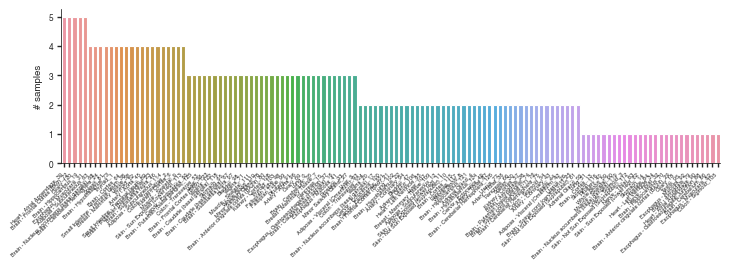

In [46]:
fig = plt.figure(figsize=(8.5, 2))

ax = sns.countplot(data=metadata_gtex_dummy, x="body_site", 
                   order=list(metadata_gtex_dummy['body_site'].value_counts().index))
ax.set_xlabel("")
ax.set_ylabel("# samples")

_ = ax.set_xticklabels(list(metadata_gtex_dummy['body_site'].value_counts().index), rotation=45, ha="right", va="top",
                       fontsize=4)

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
fig.savefig("../../figures/fig1/gtex-dummy-metadata.pdf", dpi="figure", bbox_inches="tight")

## 4. histograms: isoforms per gene + thresholded on expression

/tmp/ipykernel_160231/3705813546.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  pctax.set_yticklabels(['0%', '20%', '40%'])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


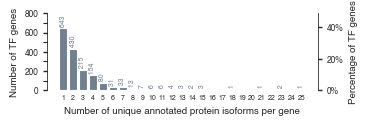

In [47]:
fig, ax = plt.subplots(1, 1, sharex=False, figsize=(3.5, 1))

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(1, x_max + 1)
ax.bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs], color="slategrey")

# label n
for h, x in zip([n_iso.value_counts().to_dict().get(x, 0) for x in xs], xs):
    if h == 0:
        continue
    ax.text(x, h, " %s" % h, rotation=90, fontsize=fontsize-2, ha="center", va="bottom",
            color="slategrey")

ax.set_xticks(xs)
ax.set_xlabel("Number of unique annotated protein isoforms per gene")
ax.tick_params(axis='x', labelsize=fontsize-2)

def num2pct(y):
    return (y / n_iso.shape[0]) * 100

def pct2num(y):
    return (y / 100) * n_iso.shape[0]


ax.set_ylim(0, 800)
ax.set_yticks(range(0, 800, 100), minor=True)
ax.set_ylabel('Number of TF genes')
for pos in ['top', 'right', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.xaxis.set_tick_params(length=0)
pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
pctax.set_ylabel('Percentage of TF genes')
pctax.set_yticks([0, 20, 40], minor=True)
pctax.set_yticklabels(['0%', '20%', '40%'])
fig.savefig('../../figures/fig1/n-isoforms-per-gene_annotated.pdf',
            bbox_inches='tight')

### GTEx: all

/tmp/ipykernel_160231/3486751682.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  pctax.set_yticklabels(['0%', '20%', '40%'])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


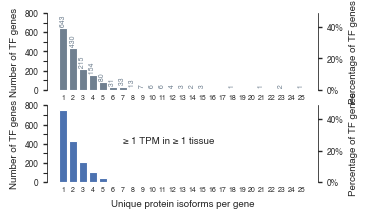

In [48]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.5, 2.2))

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(1, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs], color="slategrey")

# label n
for h, x in zip([n_iso.value_counts().to_dict().get(x, 0) for x in xs], xs):
    if h == 0:
        continue
    axs[0].text(x, h, " %s" % h, rotation=90, fontsize=fontsize-2, ha="center", va="bottom",
                color="slategrey")

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[0].set_xticks(xs)
axs[0].set_xlabel("Unique annotated protein isoforms per gene")
axs[0].tick_params(axis='x', labelsize=fontsize-2)
axs[1].set_xticks(xs)
axs[1].tick_params(axis='x', labelsize=fontsize-2)
axs[1].set_xlabel('Unique protein isoforms per gene')
#axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in ≥ 1 tissue')

def num2pct(y):
    return (y / n_iso.shape[0]) * 100

def pct2num(y):
    return (y / 100) * n_iso.shape[0]

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('Number of TF genes')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('Percentage of TF genes')
    pctax.set_yticks([0, 20, 40], minor=True)
    pctax.set_yticklabels(['0%', '20%', '40%'])
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx.pdf',
            bbox_inches='tight')

### GTEx: downsample

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


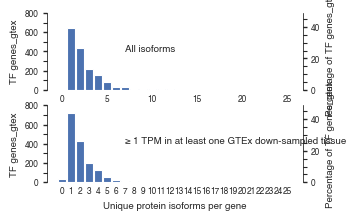

In [49]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.3, 2.2))

n_iso = (means_gtex_downsample > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_gtex_downsample > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one GTEx down-sampled tissue')

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_gtex')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('Percentage of TF genes_gtex')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx_downsamp.pdf',
            bbox_inches='tight')

### Dev

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


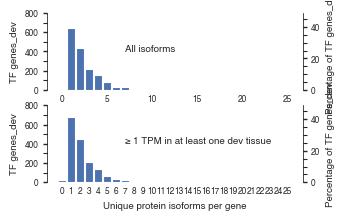

In [50]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(3.3, 2.2))

n_iso = (means_dev > 1).any(axis=1).groupby(genes_dev).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_dev > 1).any(axis=1).groupby(genes_dev).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one dev tissue')

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_dev')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('Percentage of TF genes_dev')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../../figures/fig1/n-isoforms-per-gene_by-1TPM-cutoff_hist-GTEx_dev.pdf',
            bbox_inches='tight')

## 5. ref v alt 2D heatmaps: max expression

In [51]:
ref_alt_map = pd.DataFrame([ref_isos]).T
ref_alt_map.columns = ["ref"]
ref_alt_map["gene"] = ref_alt_map["ref"].str.split("|", expand=True)[0].str[:-4]

alt_isos_df = pd.DataFrame([alt_isos]).T
alt_isos_df.columns = ["alt"]
alt_isos_df["gene"] = alt_isos_df["alt"].str.split("|", expand=True)[0].str[:-4]

ref_alt_map = ref_alt_map.merge(alt_isos_df, on="gene", how="left")
print(len(ref_alt_map))
ref_alt_map_nonan = ref_alt_map[~pd.isnull(ref_alt_map["alt"])]
print(len(ref_alt_map_nonan))
ref_alt_map_nonan.head()

2910
2305


,ref,gene,alt
0,SP2-201,SP2,SP2-202
1,ZNF280D-201,ZNF280D,ZNF280D-204
2,ZNF280D-201,ZNF280D,ZNF280D-206
3,ZNF394-201|ZNF394-208,ZNF394,ZNF394-203
5,MYCL-202,MYCL,MYCL-203


In [52]:
ref_alt_map_nonan[ref_alt_map_nonan["gene"] == "NKX2-5"]

,ref,gene,alt
513,NKX2-5-201,NKX2-5,NKX2-5-204
514,NKX2-5-201,NKX2-5,NKX2-5-202


### GTEx: all

In [53]:
means_gtex["max_gtex"] = means_gtex.max(axis=1)
means_gtex["min_gtex"] = means_gtex.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex[means_gtex["max_gtex"] > 11] = 11

print(means_gtex["max_gtex"].max())
print(means_gtex["max_gtex"].min())
means_gtex_ri = means_gtex.reset_index()
means_gtex_ri["UID_rep"] = means_gtex_ri["UID"].str.replace("_", "|")

11.0
0.0


In [54]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex", "min_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex", "min_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

1775
529


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


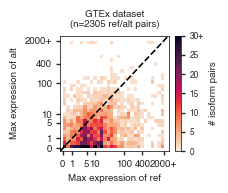

In [55]:
fig = plt.figure(figsize=(1.75, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_ref", y="max_gtex_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("Max expression of ref")
ax.set_ylabel("Max expression of alt")
ax.set_title("GTEx dataset\n(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] > ref_alt_map_nonan["max_gtex_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] < ref_alt_map_nonan["max_gtex_alt"]])
print(ar)
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-gtex.pdf',
            bbox_inches='tight')

### GTEx: downsampled

In [56]:
means_gtex_downsample["max_gtex_downsample"] = means_gtex_downsample.max(axis=1)
means_gtex_downsample["min_gtex_downsample"] = means_gtex_downsample.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex_downsample[means_gtex_downsample["max_gtex_downsample"] > 11] = 11

print(means_gtex_downsample["max_gtex_downsample"].max())
print(means_gtex_downsample["max_gtex_downsample"].min())
means_gtex_downsample_ri = means_gtex_downsample.reset_index()
means_gtex_downsample_ri["UID_rep"] = means_gtex_downsample_ri["UID"].str.replace("_", "|")

11.0
0.0


In [57]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_downsample_ri[["UID_rep", "max_gtex_downsample",
                                                                      "min_gtex_downsample"]], 
                                            left_on="ref", right_on="UID_rep", how="inner")
ref_alt_map_nonan.drop(columns=["UID_rep_ref", "UID_rep_alt"], inplace=True)
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_downsample_ri[["UID_rep", "max_gtex_downsample",
                                                                      "min_gtex_downsample"]], 
                                            left_on="alt", right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")
ref_alt_map_nonan.head()

,ref,gene,alt,max_gtex_ref,min_gtex_ref,max_gtex_alt,min_gtex_alt,UID_rep_ref,max_gtex_downsample_ref,min_gtex_downsample_ref,UID_rep_alt,max_gtex_downsample_alt,min_gtex_downsample_alt
0,SP2-201,SP2,SP2-202,4.444550,2.297742,1.132638,0.030426,SP2-201,4.709594,1.998264,SP2-202,1.384235,0.000000
1,ZNF280D-201,ZNF280D,ZNF280D-204,3.884210,0.472608,2.032604,0.193049,ZNF280D-201,3.906250,0.091573,ZNF280D-204,2.255416,0.066048
2,ZNF280D-201,ZNF280D,ZNF280D-206,3.884210,0.472608,0.763012,0.015787,ZNF280D-201,3.906250,0.091573,ZNF280D-206,1.210514,0.000000
3,ZNF394-201|ZNF394-208,ZNF394,ZNF394-203,5.839782,1.879853,2.852359,0.431567,ZNF394-201|ZNF394-208,6.297601,1.445547,ZNF394-203,3.411845,0.347990
4,MYCL-202,MYCL,MYCL-203,2.860485,0.006150,4.669695,0.143227,MYCL-202,4.123503,0.000000,MYCL-203,5.306280,0.012925


1771
NUM OF ALT ISOS THAT ARE EXPRESSED MORE HIGHLY THAN REF IN DEV RNA-SEQ: 533
PERCENT OF ALT ISOS THAT ARE EXPRESSED MORE HIGHLY THAN REF IN DEV RNA-SEQ: 23.1236442516269


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


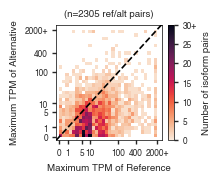

In [58]:
fig = plt.figure(figsize=(1.7, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_downsample_ref", y="max_gtex_downsample_alt",
                  bins=30, cbar=True, cbar_kws={"label": "Number of isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("Maximum TPM of Reference")
ax.set_ylabel("Maximum TPM of Alternative")
ax.set_title("(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_downsample_ref"] > ref_alt_map_nonan["max_gtex_downsample_alt"]])
print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_downsample_ref"] < ref_alt_map_nonan["max_gtex_downsample_alt"]])
print("NUM OF ALT ISOS THAT ARE EXPRESSED MORE HIGHLY THAN REF IN DEV RNA-SEQ: %s" % ar)
print("PERCENT OF ALT ISOS THAT ARE EXPRESSED MORE HIGHLY THAN REF IN DEV RNA-SEQ: %s" % (ar/len(ref_alt_map_nonan)*100))
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-gtex-downsample.pdf',
            bbox_inches='tight')

### Dev

In [59]:
means_dev["max_dev"] = means_dev.max(axis=1)
means_dev["min_dev"] = means_dev.min(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_dev[means_dev["max_dev"] > 11] = 11

print(means_dev["max_dev"].max())
print(means_dev["max_dev"].min())
means_dev_ri = means_dev.reset_index()
means_dev_ri["UID_rep"] = means_dev_ri["UID"].str.replace("_", "|")

11.0
0.0


In [60]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev", "min_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan.drop(columns=["UID_rep_ref", "UID_rep_alt"], inplace=True)
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev", "min_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")

NUM OF ALT ISOS THAT ARE EXPRESSED MORE HIGHLY THAN REF IN DEV RNA-SEQ: 551
PERCENT OF ALT ISOS THAT ARE EXPRESSED MORE HIGHLY THAN REF IN DEV RNA-SEQ: 23.904555314533624


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


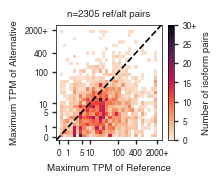

In [61]:
fig = plt.figure(figsize=(1.7, 1.5))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_dev_ref", y="max_dev_alt",
                  bins=30, cbar=True, cbar_kws={"label": "Number of isoform pairs",
                                                "ticks": [0, 5, 10, 15, 20, 25, 30]}, cmap="rocket_r",
                  vmin=0, vmax=30)

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("Maximum TPM of Reference")
ax.set_ylabel("Maximum TPM of Alternative")
ax.set_title("n=%s ref/alt pairs" % len(ref_alt_map_nonan))

ticks = [0, 1, 5, 10, 100, 400, 2000]
ticklabels = [0, 1, 5, 10, 100, 400, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "5", "10", "15", "20", "25", "30+"])

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] > ref_alt_map_nonan["max_dev_alt"]])
#print(ra)
#ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] < ref_alt_map_nonan["max_dev_alt"]])
print("NUM OF ALT ISOS THAT ARE EXPRESSED MORE HIGHLY THAN REF IN DEV RNA-SEQ: %s" % ar)
print("PERCENT OF ALT ISOS THAT ARE EXPRESSED MORE HIGHLY THAN REF IN DEV RNA-SEQ: %s" % (ar/len(ref_alt_map_nonan)*100))
#ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../../figures/fig1/expression-scatter-ref_v_alt-dev.pdf',
            bbox_inches='tight')

In [62]:
ref_alt_map_nonan.shape

(2305, 17)

## 6. per isoform: max v min ratio

removing NaNs - not counting anything where *gene* expression < 1

### GTEx: all

In [63]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# fraction where gene tpm > 1

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [64]:
print(len(f_gtex))
f_gtex["max_ratio_gtex"] = f_gtex.max(axis=1)
f_gtex["min_ratio_gtex"] = f_gtex.min(axis=1)
f_gtex_nonan = f_gtex[(~pd.isnull(f_gtex["max_ratio_gtex"])) & (~pd.isnull(f_gtex["min_ratio_gtex"]))]
print(len(f_gtex_nonan))

f_gtex_ri = f_gtex_nonan.reset_index()
f_gtex_ri["UID_rep"] = f_gtex_ri["UID"].str.replace("_", "|")

4144
4095


In [65]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan.drop(columns=["UID_rep_ref", "UID_rep_alt"], inplace=True)
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

### GTEx: downsample

In [66]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

In [67]:
print(len(f_gtex_downsample))
f_gtex_downsample["max_ratio_gtex_downsample"] = f_gtex_downsample.max(axis=1)
f_gtex_downsample["min_ratio_gtex_downsample"] = f_gtex_downsample.min(axis=1)
f_gtex_downsample_nonan = f_gtex_downsample[(~pd.isnull(f_gtex_downsample["max_ratio_gtex_downsample"])) & 
                                            (~pd.isnull(f_gtex_downsample["min_ratio_gtex_downsample"]))]
print(len(f_gtex_downsample_nonan))

f_gtex_downsample_ri = f_gtex_downsample_nonan.reset_index()
f_gtex_downsample_ri["UID_rep"] = f_gtex_downsample_ri["UID"].str.replace("_", "|")

4144
4109


In [68]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_downsample_ri[["UID_rep", "max_ratio_gtex_downsample", 
                                                       "min_ratio_gtex_downsample"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan.drop(columns=["UID_rep_ref", "UID_rep_alt"], inplace=True)
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_downsample_ri[["UID_rep", "max_ratio_gtex_downsample", 
                                                                  "min_ratio_gtex_downsample"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")


### Dev

In [69]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [70]:
print(len(f_dev))
f_dev["max_ratio_dev"] = f_dev.max(axis=1)
f_dev["min_ratio_dev"] = f_dev.min(axis=1)
f_dev_nonan = f_dev[(~pd.isnull(f_dev["max_ratio_dev"])) & (~pd.isnull(f_dev["min_ratio_dev"]))]
print(len(f_dev_nonan))

f_dev_ri = f_dev_nonan.reset_index()
f_dev_ri["UID_rep"] = f_dev_ri["UID"].str.replace("_", "|")

4144
4119


In [71]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="left")
ref_alt_map_nonan.drop(columns=["UID_rep_ref", "UID_rep_alt"], inplace=True)
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="left")

## 2D histograms to display shift/switch + barplots to quantify

In [72]:
print(len(ref_alt_map_nonan))
df = ref_alt_map_nonan[["gene", "ref", "alt", "min_ratio_dev_alt", "max_ratio_dev_alt",
                        "min_ratio_gtex_downsample_alt", "max_ratio_gtex_downsample_alt"]].drop_duplicates()
print(len(df))

df["perc_change_dev_alt"] = df["max_ratio_dev_alt"] - df["min_ratio_dev_alt"]
df["perc_change_gtex_downsample_alt"] = df["max_ratio_gtex_downsample_alt"] - df["min_ratio_gtex_downsample_alt"]

2305
2305


In [73]:
LOW_THRESH = 10
PERC_CHANGE_THRESH = 70

In [74]:
def categorize_switch(row, min_col, max_col, perc_change_col, LOW_THRESH=LOW_THRESH, PERC_CHANGE_THRESH=PERC_CHANGE_THRESH):
    if row[min_col] < LOW_THRESH and row[max_col] < LOW_THRESH:
        return "low"
    elif row[perc_change_col] > PERC_CHANGE_THRESH:
        return "switch"
    else:
        return "shift"

df["cat_dev_alt"] = df.apply(categorize_switch, min_col="min_ratio_dev_alt", max_col="max_ratio_dev_alt", 
                             perc_change_col="perc_change_dev_alt", axis=1)
df["cat_gtex_downsample_alt"] = df.apply(categorize_switch, min_col="min_ratio_gtex_downsample_alt", 
                                         max_col="max_ratio_gtex_downsample_alt", 
                                         perc_change_col="perc_change_gtex_downsample_alt", 
                                         axis=1)

In [75]:
df.cat_dev_alt.value_counts()

cat_dev_alt
shift     1482
switch     478
low        345
Name: count, dtype: int64

In [76]:
df.cat_gtex_downsample_alt.value_counts()

cat_gtex_downsample_alt
shift     1558
low        502
switch     245
Name: count, dtype: int64

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


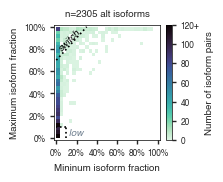

In [77]:
fig = plt.figure(figsize=(1.7, 1.5))

ax = sns.histplot(data=df, x="min_ratio_dev_alt", y="max_ratio_dev_alt",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "Number of isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_xlabel("Mininum isoform fraction")
ax.set_ylabel("Maximum isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))

# add lines to distinguish events
ax.plot([LOW_THRESH, 0], [LOW_THRESH, LOW_THRESH], linestyle="dotted", color="black")
ax.plot([LOW_THRESH, LOW_THRESH], [0, LOW_THRESH], linestyle="dotted", color="black")
ax.text(LOW_THRESH, 5, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
ax.plot([0, 100-PERC_CHANGE_THRESH], [PERC_CHANGE_THRESH, 100], linestyle="dotted", color="black")
ax.text(0, PERC_CHANGE_THRESH, "switch\n", ha="left", va="bottom", rotation=45, fontstyle="italic", color="black")
fig.savefig('../../figures/fig1/expression-ratio-scatter-alt-dev.pdf',
            bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


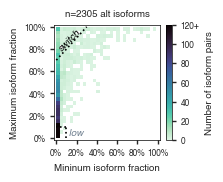

In [78]:
fig = plt.figure(figsize=(1.7, 1.5))

ax = sns.histplot(data=df, x="min_ratio_gtex_downsample_alt", y="max_ratio_gtex_downsample_alt",
                  bins=30, cbar=True, cmap="mako_r", vmin=0, vmax=120, cbar_kws={"label": "Number of isoform pairs",
                                                                                   "ticks": [0, 20, 40, 60,
                                                                                             80, 100, 120]})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(["0", "20", "40", "60", "80", "100", "120+"])
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_xlabel("Mininum isoform fraction")
ax.set_ylabel("Maximum isoform fraction")
ax.set_title("n=%s alt isoforms" % len(df))

# add lines to distinguish events
ax.plot([LOW_THRESH, 0], [LOW_THRESH, LOW_THRESH], linestyle="dotted", color="black")
ax.plot([LOW_THRESH, LOW_THRESH], [0, LOW_THRESH], linestyle="dotted", color="black")
ax.text(LOW_THRESH, 5, " low", ha="left", va="center", fontstyle="italic", color="slategrey")
ax.plot([0, 100-PERC_CHANGE_THRESH], [PERC_CHANGE_THRESH, 100], linestyle="dotted", color="black")
ax.text(0, PERC_CHANGE_THRESH, "switch\n", ha="left", va="bottom", rotation=45, fontstyle="italic", color="black")
fig.savefig('../../figures/fig1/expression-ratio-scatter-alt-gtex-downsample.pdf',
            bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


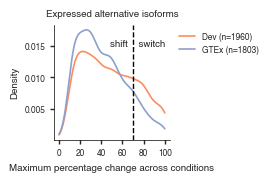

In [79]:
fig = plt.figure(figsize=(1.5, 1.5))

dev_df = df[df["cat_dev_alt"] != "low"].drop_duplicates()
gtex_df = df[df["cat_gtex_downsample_alt"] != "low"].drop_duplicates()
ax = sns.kdeplot(x=dev_df["perc_change_dev_alt"], cumulative=False, cut=0,
                 color=sns.color_palette("Set2")[1], label="Dev (n=%s)" % (len(dev_df)))
sns.kdeplot(x=gtex_df["perc_change_gtex_downsample_alt"], cut=0, 
            cumulative=False, color=sns.color_palette("Set2")[2], label="GTEx (n=%s)" % len(gtex_df), ax=ax)
ax.axvline(x=PERC_CHANGE_THRESH, color="black", linestyle="dashed", linewidth=1)
ax.text(PERC_CHANGE_THRESH, 0.016, "  switch", ha="left", va="top", fontsize=7)
ax.text(PERC_CHANGE_THRESH, 0.016, "shift  ", ha="right", va="top", fontsize=7)


plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_xlabel("Maximum percentage change across conditions")
ax.set_ylabel("Density")
ax.set_title("Expressed alternative isoforms")

_ = ax.set_xticks([0, 20, 40, 60, 80, 100])

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

fig.savefig('../../figures/fig1/perc-change-dist-gtex-v-dev.pdf',
            bbox_inches='tight')

In [80]:
barp = pd.DataFrame(df.cat_dev_alt.value_counts())
barp["cat_dev_alt_p"] = barp["count"]/barp["count"].sum(axis=0)*100

barp = barp.join(pd.DataFrame(df.cat_gtex_downsample_alt.value_counts()), lsuffix="_dev", rsuffix="_gtex_ds")
barp["cat_gtex_downsample_alt_p"] = barp["count_gtex_ds"]/barp["count_gtex_ds"].sum(axis=0)*100
barp = barp[["cat_dev_alt_p", "cat_gtex_downsample_alt_p"]].T.reset_index()
barp = barp.sort_values(by="index", ascending=False)
barp

cat_dev_alt,index,shift,switch,low
1,cat_gtex_downsample_alt_p,67.592191,10.629067,21.778742
0,cat_dev_alt_p,64.295011,20.737527,14.967462


In [81]:
palette = {"low": "lightgrey",
           "shift": sns.color_palette("mako")[1],
           "switch": sns.color_palette("mako")[5]}

In [82]:
print("PERCENT OF ALT ISOS THAT EXHIBIT SWITCHES IN GTEX (RE-SAMP): %s" % (barp[barp["index"] == "cat_gtex_downsample_alt_p"]["switch"].values[0]))
print("PERCENT OF ALT ISOS THAT EXHIBIT SWITCHES IN DEV: %s" % (barp[barp["index"] == "cat_dev_alt_p"]["switch"].values[0]))

PERCENT OF ALT ISOS THAT EXHIBIT SWITCHES IN GTEX (RE-SAMP): 10.629067245119305
PERCENT OF ALT ISOS THAT EXHIBIT SWITCHES IN DEV: 20.737527114967463


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


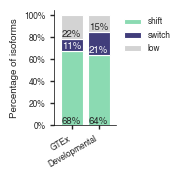

In [83]:
ax = barp.plot.bar(x="index", stacked=True, color=list(palette.values())[::-1], figsize=(0.8, 1.5),
                   width=0.8)
ax.set_ylabel("Percentage of isoforms")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)
ax.set_xticklabels(["GTEx", "Developmental"], ha="right", va="top", rotation=30)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

c = 0
for i, row in barp.iterrows():
    p_shift = row['shift']
    ax.text(c, 0, '{:.0f}%'.format(p_shift), ha="center", va="bottom", fontsize=7)
    p_switch = row['switch']
    ax.text(c, p_shift, '{:.0f}%'.format(p_switch), ha="center", va="bottom", fontsize=7, color="white")
    p_low = row['low']
    ax.text(c, p_shift+p_switch, '{:.0f}%'.format(p_low), ha="center", va="bottom", fontsize=7)
    c += 1
    
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.savefig('../../figures/fig1/expression-switch-bar-dev_vs_gtex.pdf',
            bbox_inches='tight')

### example plot: TF gene whose isoform ratios change across tissues

In [84]:
tmp = ref_alt_map_nonan
tmp["mm_gtex_ds_ref"] = tmp["max_ratio_gtex_downsample_ref"]-tmp["min_ratio_gtex_downsample_ref"]
tmp["mm_gtex_ds_alt"] = tmp["max_ratio_gtex_downsample_alt"]-tmp["min_ratio_gtex_downsample_alt"]
tmp["mm_dev_ref"] = tmp["max_ratio_dev_ref"]-tmp["min_ratio_dev_ref"]
tmp["mm_dev_alt"] = tmp["max_ratio_dev_alt"]-tmp["min_ratio_dev_alt"]
tmp["dg_ref"] = tmp["mm_dev_ref"]-tmp["mm_gtex_ds_ref"]
tmp["dg_alt"] = tmp["mm_dev_alt"]-tmp["mm_gtex_ds_alt"]
#tmp.sort_values(by="dg_alt", ascending=False).head(30)

In [85]:
if not (genes_gtex == genes_dev).all():
        raise UserWarning()
genes = genes_gtex

In [86]:
def developmental_tissue_expression_plot(gene_name, palette_name, figsize, ylim, means, cols, fig_suffix):
    n_isos = len(means.loc[genes == gene_name])
    palette = sns.color_palette(palette_name, as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[genes == gene_name, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(TPM + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('Percentage of\ngene expression')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    for spine in ['right', 'top']:
        axes[0].spines[spine].set_visible(False)
        axes[1].spines[spine].set_visible(False)
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig1/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

/tmp/ipykernel_160231/429507326.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


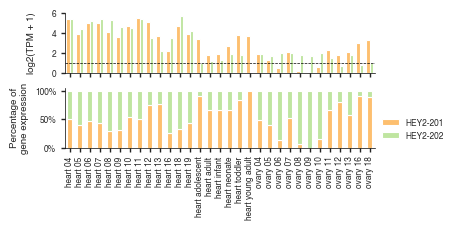

In [87]:
heart_cols = [x for x in means_dev.columns if "heart" in x]
ovary_cols = [x for x in means_dev.columns if "ovary" in x]
developmental_tissue_expression_plot("HEY2", "Spectral", (4, 1.75), (0, 6), means_dev, heart_cols + ovary_cols, 
                                     "means_dev_heart_ovary")

/tmp/ipykernel_160231/429507326.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


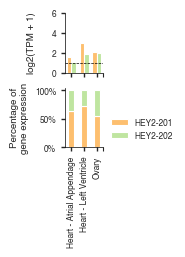

In [88]:
heart_cols = [x for x in means_gtex.columns if "Heart" in x]
ovary_cols = [x for x in means_gtex.columns if "Ovary" in x]
developmental_tissue_expression_plot("HEY2", "Spectral", (0.5, 1.75), (0, 6), means_gtex, heart_cols + ovary_cols, 
                                     "means_gtex_heart_ovary")

In [89]:
tot_genes = len(ref_alt_map_nonan.gene.unique())
tot_genes

909

In [90]:
ss_alt_gtex = len(ref_alt_map_nonan[(ref_alt_map_nonan["max_ratio_gtex_downsample_alt"] > LOW_THRESH)].gene.unique())

print("NUM TF GENES WITH >1 ISO THAT HAVE ≥1 ISO EXHIBIT SWITCH IN GTEX (RE-SAMP): %s" % ss_alt_gtex)
print("PERCENT TF GENES WITH >1 ISO THAT HAVE ≥1 ISO EXHIBIT SWITCH IN GTEX (RE-SAMP): %s" % (ss_alt_gtex/tot_genes*100))

NUM TF GENES WITH >1 ISO THAT HAVE ≥1 ISO EXHIBIT SWITCH IN GTEX (RE-SAMP): 852
PERCENT TF GENES WITH >1 ISO THAT HAVE ≥1 ISO EXHIBIT SWITCH IN GTEX (RE-SAMP): 93.72937293729373


In [91]:
ss_alt_dev = len(ref_alt_map_nonan[(ref_alt_map_nonan["max_ratio_dev_alt"] > LOW_THRESH)].gene.unique())

print("NUM TF GENES WITH >1 ISO THAT HAVE ≥1 ISO EXHIBIT SWITCH IN DEV: %s" % ss_alt_dev)
print("PERCENT TF GENES WITH >1 ISO THAT HAVE ≥1 ISO EXHIBIT SWITCH IN DEV: %s" % (ss_alt_dev/tot_genes*100))

NUM TF GENES WITH >1 ISO THAT HAVE ≥1 ISO EXHIBIT SWITCH IN DEV: 877
PERCENT TF GENES WITH >1 ISO THAT HAVE ≥1 ISO EXHIBIT SWITCH IN DEV: 96.47964796479648


## 7. calculate domain switches in annotated isoforms

In [92]:
clans = load_pfam_clans()
dbd = load_DNA_binding_domains()

In [93]:
dbd.to_csv("DBD_Pfam_IDs.txt", sep="\t", index=False)

In [94]:
pfam = pd.read_csv('../../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])

In [95]:
ref_isos = dict([(tf.name, orf.name)
            for tf in tfs.values()
            for orf in tf.isoforms
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript])
ref_isos['TBX5']

'TBX5-201'

In [96]:
# now every comparison is alt vs annotated reference isoform
df = pd.concat([g.aa_feature_disruption(ref_isos[g.name]) for g in tfs.values() if g.has_MANE_select_isoform])
df.head()

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,Pfam_domain,229,251,22,0,0,0
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,Pfam_domain,229,251,22,0,0,0
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,Pfam_domain,229,251,22,0,0,0
3,PRDM16,PRDM16-201,PRDM16-203,PF00856,Pfam_domain,94,209,115,0,0,0
4,PRDM16,PRDM16-201,PRDM16-206,PF00856,Pfam_domain,94,209,115,0,1,0


In [97]:
df[df["gene_symbol"] == "HEY2"]

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift
0,HEY2,HEY2-201,HEY2-202,PF00010,Pfam_domain,48,104,56,0,0,0
1,HEY2,HEY2-201,HEY2-202,PF07527,Pfam_domain,122,162,40,0,0,0
2,HEY2,HEY2-201,HEY2-202,PF00010_flank_N,DBD_flank,33,48,15,13,0,0
3,HEY2,HEY2-201,HEY2-202,PF00010_flank_C,DBD_flank,104,119,15,0,0,0
4,HEY2,HEY2-201,HEY2-202,Soto_Effector 0242,effector_domain,0,62,62,46,0,0
5,HEY2,HEY2-201,HEY2-202,Tycko_RD_HEY2_HUMAN_HLH_tile-nan,effector_domain,36,116,80,10,0,0
6,HEY2,HEY2-201,HEY2-202,DelRosso_RD_HEY2_1,effector_domain,41,121,80,5,0,0


In [98]:
# NES/NLS are annotated as UniProt motif
df.category.value_counts()

category
DBD_flank          7917
effector_domain    6444
Pfam_domain        5065
ZF_array           1282
UniProt motif       376
Name: count, dtype: int64

In [99]:
# loop through ref/alt pairs and calculate the % change in aas by domain type and mut type (del/ins/fs)
# i am sure there is a much faster way to do this... 

dom_types = ["Pfam_domain", "effector_domain", "UniProt motif"]
dom_names = ["Pfam", "effector", "NLS/NES"]


df_pairs = df[["gene_symbol", "ref_iso", "alt_iso"]].drop_duplicates()

dom_df = pd.DataFrame()
for i, row in df_pairs.iterrows():
    dom_sub = df[(df["gene_symbol"] == row.gene_symbol) &
                 (df["ref_iso"] == row.ref_iso) &
                 (df["alt_iso"] == row.alt_iso)]
    
    pp_str = tfs[row.gene_symbol].pairwise_changes_relative_to_reference(row.ref_iso, row.alt_iso)
    
    dom_dict_ = {}
    for dom_type, dom_name in zip(dom_types, dom_names):
        
        dom_sub_t = dom_sub[dom_sub["category"] == dom_type]
        
        nucs = []
        for j, row_j in dom_sub_t.iterrows():
            
            # correctly re-aligns domain coordinates if there are any insertions
            algned_start = _coords_transform_aa_seq_to_alignment(row_j.start_in_ref_iso, pp_str)
            algned_end = _coords_transform_aa_seq_to_alignment(row_j.end_in_ref_iso - 1, pp_str) + 1
            nuc_range = list(range(algned_start, algned_end))
            nucs.append(nuc_range)
        nucs = [item for sublist in nucs for item in sublist]
        nucs = sorted(set(nucs))
        
        pp_str_nucs = ''.join([pp_str[nuc] for nuc in nucs])
        
        if len(nucs) > 0:
            n_ins = pp_str_nucs.count("I")
            n_dd = pp_str_nucs.count("D")
            n_fs = pp_str_nucs.count("F") + pp_str_nucs.count("f")
            #print("dom: %s | ins: %s | dd: %s | fs: %s" % (dom_type, n_ins, n_dd, n_fs))

            # calculate percentage as compared to the domain length
            p_ins = n_ins/len(nucs)*100
            p_dd = n_dd/len(nucs)*100
            p_fs = n_fs/len(nucs)*100
        else:
            p_ins = np.nan
            p_dd = np.nan
            p_fs = np.nan
        
        dom_dict_[dom_name] = {"p_ins": p_ins, "p_dd": p_dd, "p_fs": p_fs}
        
    # also calculate total number of ins/dd/fs
    n_ins = pp_str.count("I")
    n_dd = pp_str.count("D")
    n_fs = pp_str.count("F") + pp_str.count("f")
    
    # calculate percentage as compared to total aa seq len
    p_ins = n_ins/len(pp_str)*100
    p_dd = n_dd/len(pp_str)*100
    p_fs = n_fs/len(pp_str)*100
        
    dom_dict_["total"] = {"p_ins": p_ins, "p_dd": p_dd, "p_fs": p_fs}
    
    dom_df_ = pd.DataFrame.from_dict(dom_dict_, orient="index").reset_index()
    dom_df_["ref_iso"] = row.ref_iso
    dom_df_["alt_iso"] = row.alt_iso
    
    dom_df = pd.concat([dom_df, dom_df_])

In [100]:
# first plot overall changes
dom_tot_df = dom_df[dom_df["index"] == "total"]
dom_tot_df = pd.melt(dom_tot_df, id_vars=["ref_iso", "alt_iso", "index"])
dom_tot_df.head()

,ref_iso,alt_iso,index,variable,value
0,PRDM16-201,PRDM16-203,total,p_ins,0.000000
1,PRDM16-201,PRDM16-206,total,p_ins,0.078309
2,PRDM16-201,PRDM16-208,total,p_ins,0.078309
3,TP73-208,TP73-201,total,p_ins,0.000000
4,TP73-208,TP73-202,total,p_ins,0.000000


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


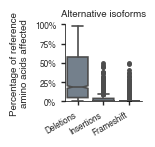

In [101]:
fig = plt.figure(figsize=(1, 1))
ax = sns.boxplot(data=dom_tot_df, 
                 x="variable", y="value", order=["p_dd", "p_ins", "p_fs"],
                 color="slategrey", fliersize=5, notch=True,
                 flierprops={"marker": "."})
mimic_r_boxplot(ax)


ax.set_xlabel("")
ax.set_xticklabels(["Deletions", "Insertions", "Frameshift"], rotation=30, ha="right", va="top")
ax.set_ylabel("Percentage of reference\namino acids affected")
ax.set_title("Alternative isoforms")
# handles, labels = ax.get_legend_handles_labels()
# labels = ["all", "Pfam", "effector"]
# ax.legend(handles, labels, loc=2, bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_yticks([0, 25, 50, 75, 100])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_ylim(0, 100)

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

fig.savefig('../../figures/fig1/seq-change-overall-boxplot.pdf',
            bbox_inches='tight')

In [102]:
dom_tot_df

,ref_iso,alt_iso,index,variable,value
0,PRDM16-201,PRDM16-203,total,p_ins,0.000000
1,PRDM16-201,PRDM16-206,total,p_ins,0.078309
2,PRDM16-201,PRDM16-208,total,p_ins,0.078309
3,TP73-208,TP73-201,total,p_ins,0.000000
4,TP73-208,TP73-202,total,p_ins,0.000000
...,...,...,...,...,...
6907,ZFY-201,ZFY-207,total,p_fs,0.000000
6908,HSFY1-201,HSFY1-202,total,p_fs,0.000000
6909,HSFY1-201,HSFY1-204,total,p_fs,0.000000
6910,HSFY2-201,HSFY2-202,total,p_fs,0.000000


In [103]:
dom_tot_df.groupby(["variable"])["value"].agg("median")

variable
p_dd     18.687302
p_fs      0.000000
p_ins     0.512547
Name: value, dtype: float64

In [104]:
print("MEDIAN PERCENT OF AMINO ACIDS DELETED COMPARED TO REF: %s" % (dom_tot_df.groupby(["variable"])["value"].agg("median").loc["p_dd"]))

MEDIAN PERCENT OF AMINO ACIDS DELETED COMPARED TO REF: 18.68730180889891


In [105]:
n_alt_10p_del = len(dom_tot_df[(dom_tot_df["variable"] == "p_dd") & (dom_tot_df["value"] >= 10)].alt_iso.unique())
p_alt_10p_del = n_alt_10p_del/len(dom_tot_df.alt_iso.unique())*100

print("NUM ALT ISOS THAT SHOW >10%% DELETIONS: %s" % n_alt_10p_del)
print("PERCENT ALT ISOS THAT SHOW >10%% DELETIONS: %s" % p_alt_10p_del)

NUM ALT ISOS THAT SHOW >10% DELETIONS: 1463
PERCENT ALT ISOS THAT SHOW >10% DELETIONS: 63.498263888888886


In [106]:
n_alt_10p_ins = len(dom_tot_df[(dom_tot_df["variable"] == "p_ins") & (dom_tot_df["value"] >= 10)].alt_iso.unique())
p_alt_10p_ins = n_alt_10p_ins/len(dom_tot_df.alt_iso.unique())*100

print("NUM ALT ISOS THAT SHOW >10%% INSERTIONS: %s" % n_alt_10p_ins)
print("PERCENT ALT ISOS THAT SHOW >10%% INSERTIONS: %s" % p_alt_10p_ins)

NUM ALT ISOS THAT SHOW >10% INSERTIONS: 195
PERCENT ALT ISOS THAT SHOW >10% INSERTIONS: 8.463541666666668


In [107]:
n_alt_10p_fs = len(dom_tot_df[(dom_tot_df["variable"] == "p_fs") & (dom_tot_df["value"] >= 10)].alt_iso.unique())
p_alt_10p_fs = n_alt_10p_fs/len(dom_tot_df.alt_iso.unique())*100

print("NUM ALT ISOS THAT SHOW >10%% FRAMESHIFTS: %s" % n_alt_10p_fs)
print("PERCENT ALT ISOS THAT SHOW >10%% FRAMESHIFTS: %s" % p_alt_10p_fs)

NUM ALT ISOS THAT SHOW >10% FRAMESHIFTS: 68
PERCENT ALT ISOS THAT SHOW >10% FRAMESHIFTS: 2.951388888888889


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


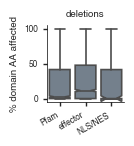

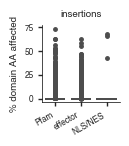

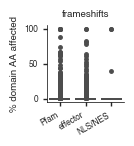

In [108]:
for mut_type, mut_name in zip(["p_dd", "p_ins", "p_fs"], ["deletions", "insertions", "frameshifts"]):
    
    dom_mut_df = pd.melt(dom_df, id_vars=["ref_iso", "alt_iso", "index"])
    dom_mut_df = dom_mut_df[dom_mut_df["variable"] == mut_type]
    

    fig = plt.figure(figsize=(1, 1))
    ax = sns.boxplot(data=dom_mut_df, 
                     x="index", y="value", order=["Pfam", "effector", "NLS/NES"],
                     color="slategrey", fliersize=5, notch=True,
                     flierprops={"marker": "."})
    mimic_r_boxplot(ax)


    ax.set_xlabel("")
    ax.set_xticklabels(["Pfam", "effector", "NLS/NES"], rotation=30, ha="right", va="top")
    ax.set_ylabel("% domain AA affected")
    ax.set_title(mut_name)

    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

    fig.savefig('../../figures/fig1/seq-change-domain-%s-boxplot.pdf' % mut_name,
                bbox_inches='tight')

In [109]:
dom_df["p_sum"] = dom_df[["p_ins", "p_dd", "p_fs"]].sum(axis=1, skipna=False)
dom_grp = dom_df[dom_df["p_sum"] > 0].groupby(["index"])["alt_iso"].agg("count")
dom_tot = dom_df[~pd.isnull(dom_df["p_sum"])].groupby(["index"])["alt_iso"].agg("count")
dom_grp

index
NLS/NES       89
Pfam        1226
effector    1331
total       2300
Name: alt_iso, dtype: int64

In [110]:
dom_tot

index
NLS/NES      257
Pfam        2185
effector    1973
total       2304
Name: alt_iso, dtype: int64

In [111]:
dom_grp/dom_tot

index
NLS/NES     0.346304
Pfam        0.561098
effector    0.674607
total       0.998264
Name: alt_iso, dtype: float64

In [112]:
dom_any = dom_df[(dom_df["index"] != "total") & (dom_df["p_sum"] > 0)]

print("NUM OF ALT ISOS THAT DIFFER IN AN ANNOTATED DOMAIN: %s" % len(dom_any.alt_iso.unique()))
print("PERCENT OF ALT ISOS THAT DIFFER IN AN ANNOTATED DOMAIN: %s" % (len(dom_any.alt_iso.unique())/len(dom_df.alt_iso.unique())*100))

NUM OF ALT ISOS THAT DIFFER IN AN ANNOTATED DOMAIN: 1728
PERCENT OF ALT ISOS THAT DIFFER IN AN ANNOTATED DOMAIN: 75.0


## 8. calculate domains that are affected compared to null

In [113]:
len(df.gene_symbol.unique())

908

In [114]:
len(df.ref_iso.unique())

908

In [115]:
len(df.alt_iso.unique())

2304

In [116]:
df['is_DBD'] = df['accession'].isin(dbd['pfam'].values) | df['accession'].str.startswith('C2H2_ZF_array')
df.head()

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift,is_DBD
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,Pfam_domain,229,251,22,0,0,0,True
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,Pfam_domain,229,251,22,0,0,0,True
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,Pfam_domain,229,251,22,0,0,0,True
3,PRDM16,PRDM16-201,PRDM16-203,PF00856,Pfam_domain,94,209,115,0,0,0,False
4,PRDM16,PRDM16-201,PRDM16-206,PF00856,Pfam_domain,94,209,115,0,1,0,False


In [117]:
df.head()

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift,is_DBD
0,PRDM16,PRDM16-201,PRDM16-203,PF00096,Pfam_domain,229,251,22,0,0,0,True
1,PRDM16,PRDM16-201,PRDM16-206,PF00096,Pfam_domain,229,251,22,0,0,0,True
2,PRDM16,PRDM16-201,PRDM16-208,PF00096,Pfam_domain,229,251,22,0,0,0,True
3,PRDM16,PRDM16-201,PRDM16-203,PF00856,Pfam_domain,94,209,115,0,0,0,False
4,PRDM16,PRDM16-201,PRDM16-206,PF00856,Pfam_domain,94,209,115,0,1,0,False


In [118]:
# TODO: move to isolib.py
df['is_affected_at_all'] = (df['deletion'] + df['insertion'] + df['frameshift']) > 0
for frac in [1.0, 0.9, 0.5, 0.1]:
    df[f"is_affected_{frac * 100:.0f}pct"] = (df['deletion'] + df['insertion'] + df['frameshift']) >= frac * df['length']

dbd_acc = set(dbd['pfam'].values).union(
            set(df['accession'][df['accession'].str.startswith('C2H2_ZF_array')].unique())
            )

In [119]:
df[df['gene_symbol'] == 'ATF2']

,gene_symbol,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,deletion,insertion,frameshift,is_DBD,is_affected_at_all,is_affected_100pct,is_affected_90pct,is_affected_50pct,is_affected_10pct
0,ATF2,ATF2-201,ATF2-202,PF00170,Pfam_domain,349,413,64,0,0,0,True,False,False,False,False,False
1,ATF2,ATF2-201,ATF2-204,PF00170,Pfam_domain,349,413,64,0,0,0,True,False,False,False,False,False
2,ATF2,ATF2-201,ATF2-205,PF00170,Pfam_domain,349,413,64,46,0,0,True,True,False,False,True,True
3,ATF2,ATF2-201,ATF2-207,PF00170,Pfam_domain,349,413,64,64,0,0,True,True,True,True,True,True
4,ATF2,ATF2-201,ATF2-212,PF00170,Pfam_domain,349,413,64,0,0,0,True,False,False,False,False,False
5,ATF2,ATF2-201,ATF2-221,PF00170,Pfam_domain,349,413,64,0,0,0,True,False,False,False,False,False
6,ATF2,ATF2-201,ATF2-202,PF00096,Pfam_domain,24,49,25,16,0,9,True,True,True,True,True,True
7,ATF2,ATF2-201,ATF2-204,PF00096,Pfam_domain,24,49,25,0,0,0,True,False,False,False,False,False
8,ATF2,ATF2-201,ATF2-205,PF00096,Pfam_domain,24,49,25,15,0,0,True,True,False,False,True,True
9,ATF2,ATF2-201,ATF2-207,PF00096,Pfam_domain,24,49,25,0,0,0,True,False,False,False,False,False


In [120]:
dbd['clan'] = dbd['pfam'].map(clans)
dbd['num_genes'] = dbd['pfam'].map(df.groupby('accession')['gene_symbol'].size())

In [121]:
def is_DBD(domain):
    return (domain.accession in dbd['pfam'].values) or domain.accession.startswith('C2H2_ZF_array')

n_aa_dbd = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if is_DBD(dom)]
n_aa_pfam = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'Pfam_domain']
n_aa_effector = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'effector_domain']
n_aa_nls = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'UniProt motif']

In [122]:
df.loc[df['accession'].str.startswith('C2H2_ZF_array'), 'accession'] = 'C2H2_ZF_array'
doms = (df.loc[(df['category'] == 'Pfam_domain') | 
              (df['category'] == 'ZF_array'), :]
              .groupby('accession')
              ['alt_iso']
              .nunique()
              .to_frame(name='n_alt_iso'))
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
                        (df['category'] == 'ZF_array'), :]
                        .groupby(['accession', 'alt_iso'])
                        [c]
                        .any()
                        .groupby(level='accession').sum())
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)

In [123]:
%%time
# again, explicitly compare ref v alt
df_null = pd.concat([g.null_fraction_per_aa_feature(ref_isos[g.name]) for g in tfs.values() if g.has_MANE_select_isoform])

df = pd.merge(df, df_null, how='left', on=['gene_symbol', 'ref_iso', 'alt_iso', 'length'])

CPU times: user 2min 25s, sys: 210 ms, total: 2min 26s
Wall time: 2min 27s


In [124]:
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.loc[(df['category'] == 'Pfam_domain') |
                    (df['category'] == 'ZF_array'), :]
                .groupby(['accession', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('accession').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('accession').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('accession').apply(null_quantile, 0.5)

In [125]:
doms['is_DBD'] = doms.index.isin(dbd['pfam'].values) | (doms.index == 'C2H2_ZF_array')
# Use the custom DBD names
doms.loc[doms['is_DBD'], 'domain_name'] = doms[doms['is_DBD']].index.map(dbd.set_index('pfam')['dbd'])
doms.loc[~doms['is_DBD'], 'domain_name'] = doms[~doms['is_DBD']].index.map(pfam.set_index('pfam_accession')['name'])
doms.loc[doms.index == 'C2H2_ZF_array', 'domain_name'] = ['C2H2 ZF array']

In [126]:
dom_affected_levels = [c[5:] for c in doms.columns if c.startswith('f_is_affected_')]
level_desc = {'affected_at_all': 'at least partial domain removal',
 'affected_100pct': '100% removal',
 'affected_90pct': '≥ 90% removal',
 'affected_50pct': '≥ 50% removal',
 'affected_10pct': '≥ 10% removal'}

In [127]:
# all domains, all DBD, non-DBD
doms = df.groupby('is_DBD')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['is_DBD', 'alt_iso'])
                        [c]
                        .any()
                        .groupby(level='is_DBD')
                        .sum())
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']


doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['is_DBD', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('is_DBD').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('is_DBD').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('is_DBD').apply(null_quantile, 0.5)
doms.head()

,n_alt_iso,n_is_affected_at_all,f_is_affected_at_all,n_is_affected_100pct,f_is_affected_100pct,n_is_affected_90pct,f_is_affected_90pct,n_is_affected_50pct,f_is_affected_50pct,n_is_affected_10pct,...,null_fraction_affected_100pct_center,null_fraction_affected_90pct_99CI_low,null_fraction_affected_90pct_99CI_high,null_fraction_affected_90pct_center,null_fraction_affected_50pct_99CI_low,null_fraction_affected_50pct_99CI_high,null_fraction_affected_50pct_center,null_fraction_affected_10pct_99CI_low,null_fraction_affected_10pct_99CI_high,null_fraction_affected_10pct_center
is_DBD,,,,,,,,,,,,,,,,,,,,,
False,2269,1762,0.776554,1050,0.462759,1084,0.477743,1298,0.572058,1631,...,0.570295,0.564566,0.593213,0.579110,0.617453,0.646540,0.631996,0.689731,0.718819,0.704275
True,2178,1031,0.473370,760,0.348944,770,0.353535,856,0.393021,988,...,0.421488,0.414141,0.443985,0.428834,0.452709,0.484389,0.468779,0.509642,0.543618,0.526630


In [128]:
df['category_a'] = np.nan
df.loc[df['is_DBD'], 'category_a'] = 'DBD'
df.loc[(df['category'] == 'Pfam_domain') & ~df['is_DBD'], 'category_a'] = 'Other Pfam domain'
df.loc[(df['category'] == 'effector_domain'), 'category_a'] = 'Effector domain'
df.loc[(df['category'] == 'UniProt motif'), 'category_a'] = 'NLS/NES'

In [129]:
# split by domain type
doms = df.groupby('category_a')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['category_a', 'alt_iso'])
                        [c]
                        .any()
                        .groupby(level='category_a')
                        .sum())
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)

    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['category_a', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('category_a').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('category_a').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('category_a').apply(null_quantile, 0.5)

data = doms.copy()

/tmp/ipykernel_160231/3286175673.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["DBD", "Other Pfam domain", "Effector domain", "NLS/NES"])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData arr

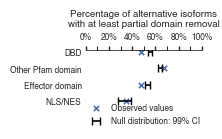

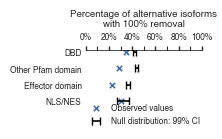

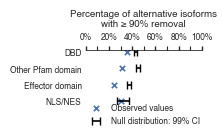

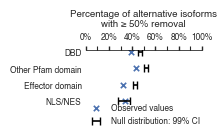

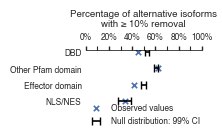

In [130]:
for level in dom_affected_levels:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(w=1.5, h=0.7)

        #ax.barh(data.index, 
        #        data[f'f_is_{level}'].values * 100,
        #        label='Observed values',
        #        color=sns.color_palette("Set2")[0])
        ax.scatter(y=data.index, 
                   x=data[f'f_is_{level}'].values * 100,
                   label='Observed values',
                   s=15,
                   marker='x',
                   color='C0')

        ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                        (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                                fmt='none',
                                capsize=3,
                                color='black',
                                label='Null distribution: 99% CI')
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.55), frameon=False)
        ax.set_xlim(0, 100)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.yaxis.set_tick_params(length=0)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.tick_top()
        ax.set_yticklabels(["DBD", "Other Pfam domain", "Effector domain", "NLS/NES"])
        ax.set_xlabel(f'Percentage of alternative isoforms\nwith {level_desc[level]}')
        ax.xaxis.set_label_position('top')
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticks(range(0, 101, 10), minor=True)
        ax.set_xticklabels([f'{x}%' for x in ax.get_xticks()])
        plt.savefig(f'../../figures/fig1/domain_categories_{level}.resized.pdf'.format(level),
                bbox_inches='tight')

In [131]:
print("total # ref. isoforms w/ annotated NLS/NES: %s" % (len(df[df["category"] == "UniProt motif"].ref_iso.unique())))
print("total # ref. isoforms w/ annotated NLS: %s" % (len(df[(df["category"] == "UniProt motif") &
                                                             (df["accession"].str.contains("NLS"))].ref_iso.unique())))
print("total # ref. isoforms w/ annotated NES: %s" % (len(df[(df["category"] == "UniProt motif") &
                                                             (df["accession"].str.contains("NES"))].ref_iso.unique())))

total # ref. isoforms w/ annotated NLS/NES: 73
total # ref. isoforms w/ annotated NLS: 69
total # ref. isoforms w/ annotated NES: 12


### more granular plots

In [132]:
doms = (df.loc[(df['category'] == 'Pfam_domain') | 
              (df['category'] == 'ZF_array'), :]
              .groupby('accession')
              ['alt_iso']
              .nunique()
              .to_frame(name='n_alt_iso'))
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
                        (df['category'] == 'ZF_array'), :]
                        .groupby(['accession', 'alt_iso'])
                        [c]
                        .any()
                        .groupby(level='accession')
                        .sum())
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.loc[(df['category'] == 'Pfam_domain') |
                    (df['category'] == 'ZF_array'), :]
                .groupby(['accession', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('accession').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('accession').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('accession').apply(null_quantile, 0.5)

In [133]:
doms['is_DBD'] = doms.index.isin(dbd['pfam'].values) | (doms.index == 'C2H2_ZF_array')
# Use the custom DBD names
doms.loc[doms['is_DBD'], 'domain_name'] = doms[doms['is_DBD']].index.map(dbd.set_index('pfam')['dbd'])
doms.loc[~doms['is_DBD'], 'domain_name'] = doms[~doms['is_DBD']].index.map(pfam.set_index('pfam_accession')['name'])
doms.loc[doms.index == 'C2H2_ZF_array', 'domain_name'] = ['C2H2 ZF array']
doms.head()

,n_alt_iso,n_is_affected_at_all,f_is_affected_at_all,n_is_affected_100pct,f_is_affected_100pct,n_is_affected_90pct,f_is_affected_90pct,n_is_affected_50pct,f_is_affected_50pct,n_is_affected_10pct,...,null_fraction_affected_90pct_99CI_high,null_fraction_affected_90pct_center,null_fraction_affected_50pct_99CI_low,null_fraction_affected_50pct_99CI_high,null_fraction_affected_50pct_center,null_fraction_affected_10pct_99CI_low,null_fraction_affected_10pct_99CI_high,null_fraction_affected_10pct_center,is_DBD,domain_name
accession,,,,,,,,,,,,,,,,,,,,,
C2H2_ZF_array,931,524,0.562836,410,0.440387,415,0.445757,448,0.481203,504,...,0.500537,0.484425,0.504834,0.539205,0.522019,0.569280,0.610097,0.589689,True,C2H2 ZF array
PF01352,537,241,0.448790,108,0.201117,116,0.216015,174,0.324022,194,...,0.551210,0.525140,0.513966,0.567970,0.540037,0.527002,0.581006,0.554935,False,KRAB box
PF00096,383,183,0.477807,175,0.456919,175,0.456919,179,0.467363,180,...,0.503916,0.467363,0.441253,0.509138,0.475196,0.446475,0.516971,0.483029,True,C2H2 ZF
PF00046,192,75,0.390625,52,0.270833,53,0.276042,62,0.322917,74,...,0.411458,0.354167,0.328125,0.447917,0.390625,0.369792,0.494792,0.432292,True,Homeodomain
PF00010,142,55,0.387324,28,0.197183,29,0.204225,34,0.239437,46,...,0.359155,0.295775,0.260563,0.401408,0.330986,0.302817,0.450704,0.380282,True,bHLH


In [134]:
cutoff = 30

/tmp/ipykernel_160231/603113460.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
/tmp/ipykernel_160231/603113460.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
/tmp/ipykernel_160231/603113460.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)

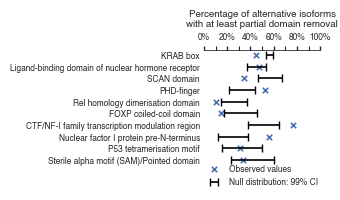

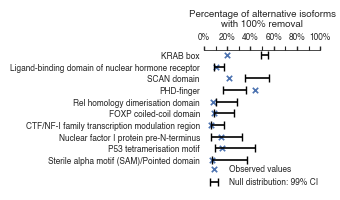

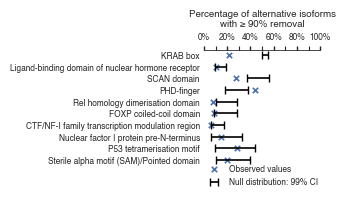

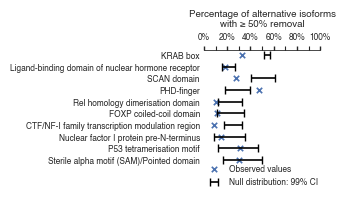

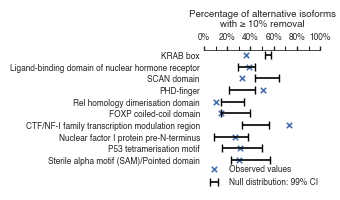

In [135]:
for level in dom_affected_levels:

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(w=1.5, h=1.5)
    data = doms.loc[~doms['is_DBD'] &
                    (doms['n_alt_iso'] >= cutoff) &
                     ~(doms.index.map(clans) == 'CL0361'), :].copy()
    #ax.barh(data.index, 
    #        data[f'f_is_{level}'].values * 100,
    #        label='Observed values',
    #        color=sns.color_palette("Set2")[0])
    ax.scatter(y=data.index, 
                   x=data[f'f_is_{level}'].values * 100,
                   label='Observed values',
                   s=15,
                   marker='x',
                   color='C0')

    ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                      (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                fmt='none',
                capsize=3,
                color='black',
                label='Null distribution: 99% CI')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), frameon=False)
    ax.set_yticklabels(data['domain_name'].values)
    ax.set_xlim(0, 100)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.yaxis.set_tick_params(length=0)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.tick_top()
    ax.set_xlabel(f'Percentage of alternative isoforms\nwith {level_desc[level]}')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(0, 101, 20))
    ax.set_xticks(range(0, 101, 10), minor=True)
    ax.set_xticklabels([f'{x}%' for x in ax.get_xticks()])
    plt.savefig(f'../../figures/fig1/other_domain_{level}.resized.pdf'.format(level),
                bbox_inches='tight')

## 9. calculate splicing types for ref/alt pairs

In [136]:
alt_isos = {}
for tf in tfs.values():
    if tf.has_MANE_select_isoform:
        alts = []
        for orf in tf.isoforms:
            if not orf.is_MANE_select_transcript:
                alts.append(orf.name)
    alt_isos[tf.name] = alts
alt_isos["TBX5"]

['TBX5-202', 'TBX5-204']

In [137]:
df = pd.DataFrame([g.splicing_categories(ref_isos[g.name], alt_iso) for g in tfs.values() if g.has_MANE_select_isoform for alt_iso in alt_isos[g.name]])
df[df["gene_symbol"] == "TBX5"]

,gene_symbol,reference isoform,alternative isoform,alternative N-terminal,alternative C-terminal,alternative internal exon,alternative 5' splice site,alternative 3' splice site,exon skipping,mutually exclusive exons,intron retention
1232,TBX5,TBX5-201,TBX5-202,True,False,False,False,True,False,False,False
1233,TBX5,TBX5-201,TBX5-204,False,True,False,True,False,False,False,False


In [138]:
df_m = pd.melt(df, id_vars=["gene_symbol", "reference isoform", "alternative isoform"])
df_m.head()

,gene_symbol,reference isoform,alternative isoform,variable,value
0,PRDM16,PRDM16-201,PRDM16-203,alternative N-terminal,False
1,PRDM16,PRDM16-201,PRDM16-206,alternative N-terminal,False
2,PRDM16,PRDM16-201,PRDM16-208,alternative N-terminal,False
3,TP73,TP73-208,TP73-206,alternative N-terminal,True
4,TP73,TP73-208,TP73-207,alternative N-terminal,True


In [139]:
df_m_t = df_m[df_m["value"] == True]
df_m_t.groupby("variable")["alternative isoform"].agg("count")

variable
alternative 3' splice site    1046
alternative 5' splice site     786
alternative C-terminal         991
alternative N-terminal         938
alternative internal exon      751
exon skipping                  588
intron retention               111
mutually exclusive exons        43
Name: alternative isoform, dtype: int64

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


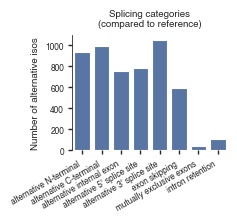

In [140]:
fig = plt.figure(figsize=(2, 1.5))


ax = sns.countplot(data=df_m_t, x="variable", color=sns.color_palette()[0])

ax.set_xlabel("")
xticklabels = ax.get_xticklabels()
_ = ax.set_xticklabels(xticklabels, rotation=30, va="top", ha="right")

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel("Number of alternative isos")
ax.set_title("Splicing categories\n(compared to reference)")

fig.savefig("../../figures/fig1/splicing_categories.pdf", dpi="figure", bbox_inches="tight")